In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\test.csv', parse_dates=['date'])
sample_sub = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\sample_submission.csv')
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))
train.head()

Train shape:(913000, 4), Test shape:(45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
print("number of unique items :",train.item.nunique())
print("number of unique store :",train.store.nunique())

number of unique items : 50
number of unique store : 10


In [4]:
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['dayofweek'] = train.date.dt.dayofweek
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekofyear'] = train.date.dt.weekofyear
train.head()

,date,store,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,2013-01-01,1,1,13,1,1,1,1,2013,1
1,2013-01-02,1,1,11,2,2,2,1,2013,1
2,2013-01-03,1,1,14,3,3,3,1,2013,1
3,2013-01-04,1,1,13,4,4,4,1,2013,1
4,2013-01-05,1,1,10,5,5,5,1,2013,1


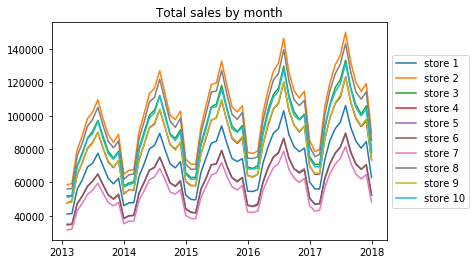

In [5]:
for i in range(1,11):
    month_df = train[train.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index)
    y=np.array(month_df.sales)
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total sales by month")
plt.show()

Text(0.5, 1.0, 'Store/ Item sales heatmap')

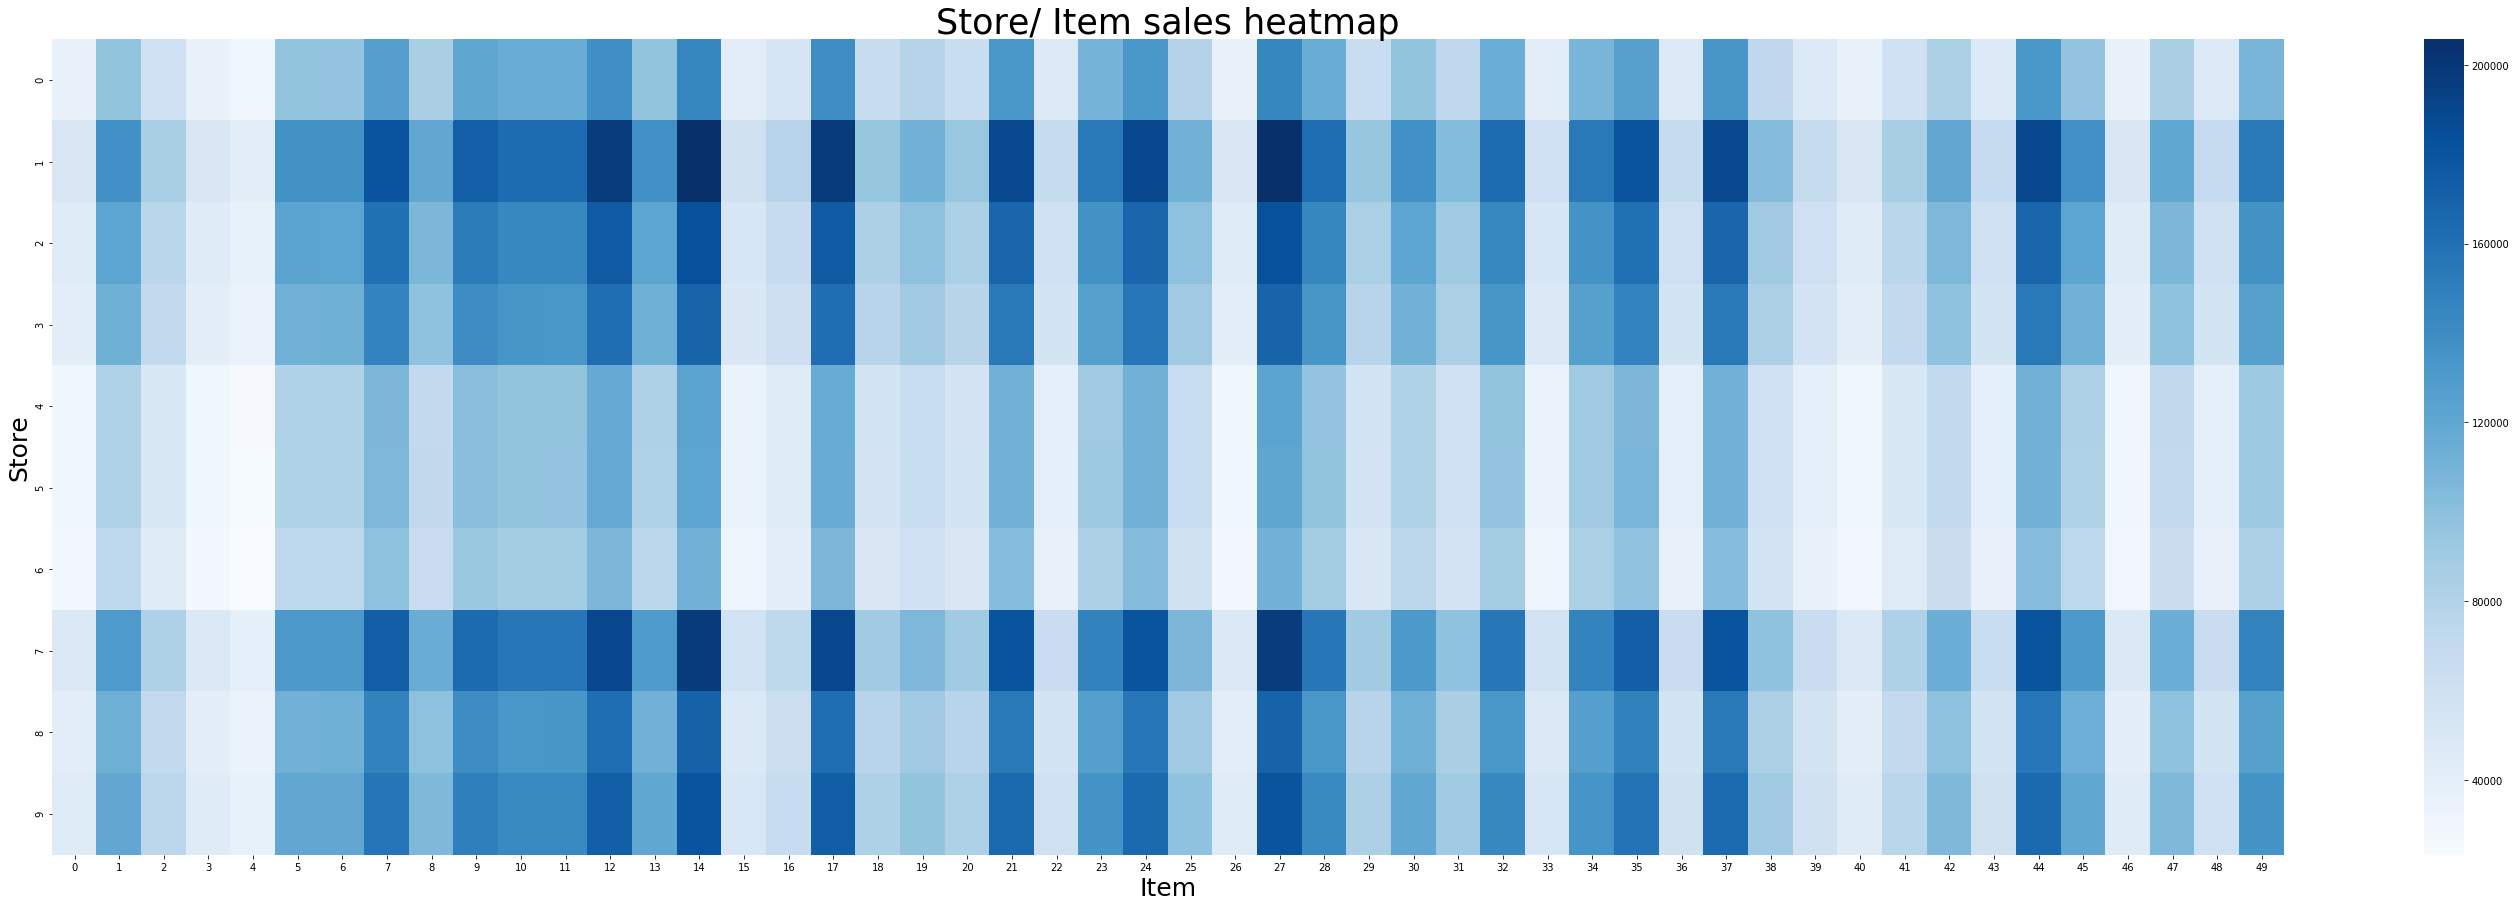

In [6]:
store_item_df = train.groupby(['store','item']).sum()
matrixStoreItem = np.zeros((10,50))
for i in range(1,11):
    for j in range(1,51):
        matrixStoreItem[i-1,j-1] = store_item_df.loc[i,j].sales

plt.figure(figsize=(50,15))
ax = sns.heatmap(matrixStoreItem,cmap='Blues')
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Store",fontsize=25)
plt.title("Store/ Item sales heatmap",fontsize=35)

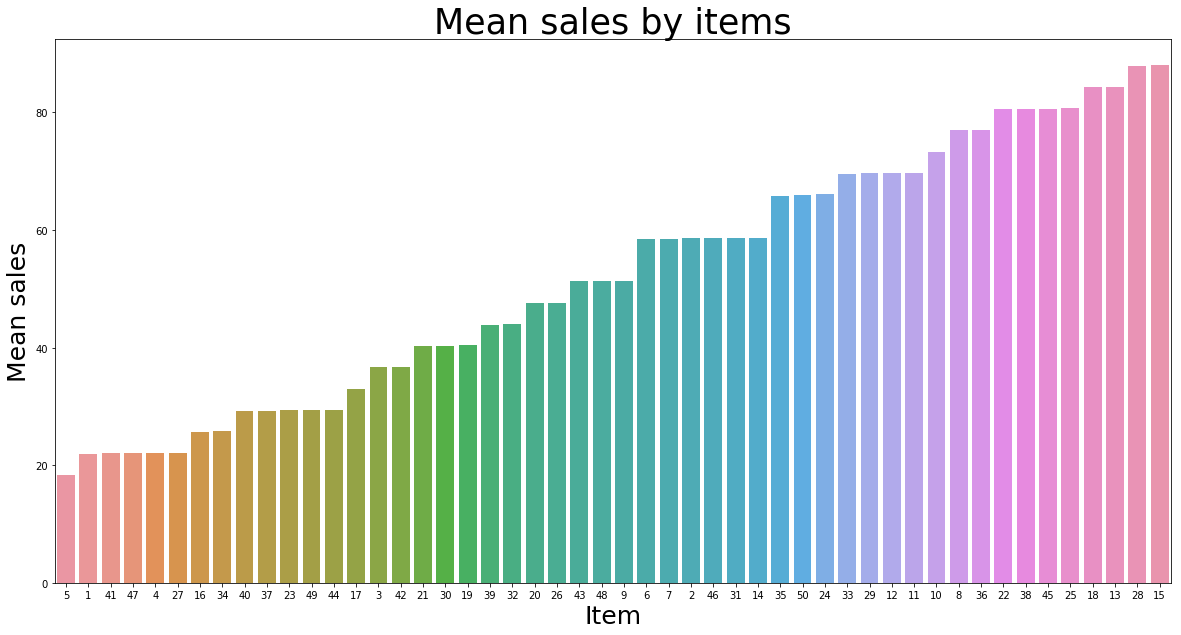

In [7]:
plt.close('all')
item_df = train.groupby(['item']).mean()
item_df.sort_values('sales',ascending=True,inplace=True)
x = item_df.index
y = item_df.sales
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y, order=x)
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Mean sales",fontsize=25)
plt.title("Mean sales by items",fontsize=35)
plt.show()

In [8]:
df = pd.get_dummies(train, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df.head()

,date,sales,dayofyear,year,store_1,store_2,store_3,store_4,store_5,store_6,...,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53
0,2013-01-01,13,1,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11,2,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,3,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,4,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,5,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]
print("train shape: ",df_train.shape)
print("validation shape :",df_val.shape)

train shape:  (730700, 167)
validation shape : (182300, 167)


In [10]:
df_train.drop('date',axis=1,inplace=True)
df_val.drop('date',axis=1,inplace=True)
y_train = df_train['sales'].values
y_test = df_val['sales'].values
X_train = df_train.drop('sales', axis=1).values
X_test = df_val.drop('sales', axis=1).values

C:\Users\gmjj0\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'rmse'}, 'num_leaves': 10, 'learning_rate': 0.05, 
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':100, 'nthread':-1}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 28.6184
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 28.3921
[3]	valid_0's rmse: 28.2098
[4]	valid_0's rmse: 27.9967
[5]	valid_0's rmse: 27.81
[6]	valid_0's rmse: 27.6247
[7]	valid_0's rmse: 27.4295
[8]	valid_0's rmse: 27.2633
[9]	valid_0's rmse: 27.1004
[10]	valid_0's rmse: 26.9275
[11]	valid_0's rmse: 26.7593
[12]	valid_0's rmse: 26.5837
[13]	valid_0's rmse: 26.4083
[14]	valid_0's rmse: 26.2603
[15]	valid_0's rmse: 26.1225
[16]	valid_0's rmse: 25.9629
[17]	valid_0's rmse: 25.7999
[18]	valid_0's rmse: 25.6321
[19]	valid_0's rmse: 25.4777
[20]	valid_0's rmse: 25.3431
[21]	valid_0's rmse: 25.2084
[22]	valid_0's rmse: 25.0591
[23]	valid_0's rmse: 24.9131
[24]	valid_0's rmse: 24.7765
[25]	valid_0's rmse: 24.6387
[26]	valid_0's rmse: 24.5144
[27]	valid_0's rmse: 24.3839
[28]	valid_0's rmse: 24.2472
[29]	valid_0's rmse: 24.1447
[30]	valid_0's rmse: 24.0149
[31]	valid_0's rmse: 23.8799
[32]	valid_0's rmse: 23.7441
[33]	valid_0's rmse:

[277]	valid_0's rmse: 11.1935
[278]	valid_0's rmse: 11.1776
[279]	valid_0's rmse: 11.1602
[280]	valid_0's rmse: 11.1453
[281]	valid_0's rmse: 11.1276
[282]	valid_0's rmse: 11.113
[283]	valid_0's rmse: 11.096
[284]	valid_0's rmse: 11.0765
[285]	valid_0's rmse: 11.0611
[286]	valid_0's rmse: 11.0443
[287]	valid_0's rmse: 11.0295
[288]	valid_0's rmse: 11.0145
[289]	valid_0's rmse: 11.0003
[290]	valid_0's rmse: 10.9833
[291]	valid_0's rmse: 10.9678
[292]	valid_0's rmse: 10.9524
[293]	valid_0's rmse: 10.9361
[294]	valid_0's rmse: 10.9221
[295]	valid_0's rmse: 10.9087
[296]	valid_0's rmse: 10.8948
[297]	valid_0's rmse: 10.8796
[298]	valid_0's rmse: 10.862
[299]	valid_0's rmse: 10.8467
[300]	valid_0's rmse: 10.8308
[301]	valid_0's rmse: 10.8161
[302]	valid_0's rmse: 10.8031
[303]	valid_0's rmse: 10.7884
[304]	valid_0's rmse: 10.7751
[305]	valid_0's rmse: 10.7624
[306]	valid_0's rmse: 10.7491
[307]	valid_0's rmse: 10.7329
[308]	valid_0's rmse: 10.717
[309]	valid_0's rmse: 10.7035
[310]	valid_0'

[553]	valid_0's rmse: 9.0702
[554]	valid_0's rmse: 9.0675
[555]	valid_0's rmse: 9.06519
[556]	valid_0's rmse: 9.06291
[557]	valid_0's rmse: 9.05982
[558]	valid_0's rmse: 9.05677
[559]	valid_0's rmse: 9.05398
[560]	valid_0's rmse: 9.05139
[561]	valid_0's rmse: 9.04872
[562]	valid_0's rmse: 9.04593
[563]	valid_0's rmse: 9.0429
[564]	valid_0's rmse: 9.04012
[565]	valid_0's rmse: 9.03743
[566]	valid_0's rmse: 9.03491
[567]	valid_0's rmse: 9.03206
[568]	valid_0's rmse: 9.02921
[569]	valid_0's rmse: 9.02674
[570]	valid_0's rmse: 9.02396
[571]	valid_0's rmse: 9.02118
[572]	valid_0's rmse: 9.01862
[573]	valid_0's rmse: 9.01605
[574]	valid_0's rmse: 9.01358
[575]	valid_0's rmse: 9.01095
[576]	valid_0's rmse: 9.00897
[577]	valid_0's rmse: 9.00585
[578]	valid_0's rmse: 9.00284
[579]	valid_0's rmse: 9.00051
[580]	valid_0's rmse: 8.99794
[581]	valid_0's rmse: 8.99543
[582]	valid_0's rmse: 8.99295
[583]	valid_0's rmse: 8.99077
[584]	valid_0's rmse: 8.98801
[585]	valid_0's rmse: 8.985
[586]	valid_0's

[833]	valid_0's rmse: 8.59269
[834]	valid_0's rmse: 8.59179
[835]	valid_0's rmse: 8.59019
[836]	valid_0's rmse: 8.58916
[837]	valid_0's rmse: 8.58799
[838]	valid_0's rmse: 8.58654
[839]	valid_0's rmse: 8.58549
[840]	valid_0's rmse: 8.58432
[841]	valid_0's rmse: 8.58279
[842]	valid_0's rmse: 8.58223
[843]	valid_0's rmse: 8.58135
[844]	valid_0's rmse: 8.58022
[845]	valid_0's rmse: 8.57933
[846]	valid_0's rmse: 8.57856
[847]	valid_0's rmse: 8.57735
[848]	valid_0's rmse: 8.57645
[849]	valid_0's rmse: 8.57541
[850]	valid_0's rmse: 8.57453
[851]	valid_0's rmse: 8.57365
[852]	valid_0's rmse: 8.5728
[853]	valid_0's rmse: 8.57191
[854]	valid_0's rmse: 8.57092
[855]	valid_0's rmse: 8.56984
[856]	valid_0's rmse: 8.56832
[857]	valid_0's rmse: 8.56739
[858]	valid_0's rmse: 8.56645
[859]	valid_0's rmse: 8.56526
[860]	valid_0's rmse: 8.56433
[861]	valid_0's rmse: 8.56292
[862]	valid_0's rmse: 8.56173
[863]	valid_0's rmse: 8.56059
[864]	valid_0's rmse: 8.55928
[865]	valid_0's rmse: 8.55804
[866]	valid

[1107]	valid_0's rmse: 8.3543
[1108]	valid_0's rmse: 8.3534
[1109]	valid_0's rmse: 8.35261
[1110]	valid_0's rmse: 8.35197
[1111]	valid_0's rmse: 8.35117
[1112]	valid_0's rmse: 8.35025
[1113]	valid_0's rmse: 8.34982
[1114]	valid_0's rmse: 8.34899
[1115]	valid_0's rmse: 8.3488
[1116]	valid_0's rmse: 8.34825
[1117]	valid_0's rmse: 8.34781
[1118]	valid_0's rmse: 8.34713
[1119]	valid_0's rmse: 8.34637
[1120]	valid_0's rmse: 8.34572
[1121]	valid_0's rmse: 8.34521
[1122]	valid_0's rmse: 8.34477
[1123]	valid_0's rmse: 8.34416
[1124]	valid_0's rmse: 8.34373
[1125]	valid_0's rmse: 8.34339
[1126]	valid_0's rmse: 8.34301
[1127]	valid_0's rmse: 8.34269
[1128]	valid_0's rmse: 8.34207
[1129]	valid_0's rmse: 8.34135
[1130]	valid_0's rmse: 8.34077
[1131]	valid_0's rmse: 8.34019
[1132]	valid_0's rmse: 8.33993
[1133]	valid_0's rmse: 8.33933
[1134]	valid_0's rmse: 8.33861
[1135]	valid_0's rmse: 8.33815
[1136]	valid_0's rmse: 8.33739
[1137]	valid_0's rmse: 8.3368
[1138]	valid_0's rmse: 8.33611
[1139]	valid

[1375]	valid_0's rmse: 8.19267
[1376]	valid_0's rmse: 8.19245
[1377]	valid_0's rmse: 8.19194
[1378]	valid_0's rmse: 8.19115
[1379]	valid_0's rmse: 8.19055
[1380]	valid_0's rmse: 8.19011
[1381]	valid_0's rmse: 8.18969
[1382]	valid_0's rmse: 8.18924
[1383]	valid_0's rmse: 8.18911
[1384]	valid_0's rmse: 8.18857
[1385]	valid_0's rmse: 8.18787
[1386]	valid_0's rmse: 8.18737
[1387]	valid_0's rmse: 8.18656
[1388]	valid_0's rmse: 8.18605
[1389]	valid_0's rmse: 8.18555
[1390]	valid_0's rmse: 8.18508
[1391]	valid_0's rmse: 8.18487
[1392]	valid_0's rmse: 8.18423
[1393]	valid_0's rmse: 8.18407
[1394]	valid_0's rmse: 8.18378
[1395]	valid_0's rmse: 8.18328
[1396]	valid_0's rmse: 8.1831
[1397]	valid_0's rmse: 8.18262
[1398]	valid_0's rmse: 8.18201
[1399]	valid_0's rmse: 8.18165
[1400]	valid_0's rmse: 8.18047
[1401]	valid_0's rmse: 8.18006
[1402]	valid_0's rmse: 8.17937
[1403]	valid_0's rmse: 8.17896
[1404]	valid_0's rmse: 8.17878
[1405]	valid_0's rmse: 8.17846
[1406]	valid_0's rmse: 8.17691
[1407]	va

[1643]	valid_0's rmse: 8.07225
[1644]	valid_0's rmse: 8.0721
[1645]	valid_0's rmse: 8.07161
[1646]	valid_0's rmse: 8.07145
[1647]	valid_0's rmse: 8.07059
[1648]	valid_0's rmse: 8.07
[1649]	valid_0's rmse: 8.06958
[1650]	valid_0's rmse: 8.06949
[1651]	valid_0's rmse: 8.06907
[1652]	valid_0's rmse: 8.06892
[1653]	valid_0's rmse: 8.06867
[1654]	valid_0's rmse: 8.06846
[1655]	valid_0's rmse: 8.06807
[1656]	valid_0's rmse: 8.06789
[1657]	valid_0's rmse: 8.06763
[1658]	valid_0's rmse: 8.06715
[1659]	valid_0's rmse: 8.06641
[1660]	valid_0's rmse: 8.06612
[1661]	valid_0's rmse: 8.06596
[1662]	valid_0's rmse: 8.06527
[1663]	valid_0's rmse: 8.06489
[1664]	valid_0's rmse: 8.06443
[1665]	valid_0's rmse: 8.06391
[1666]	valid_0's rmse: 8.06378
[1667]	valid_0's rmse: 8.06349
[1668]	valid_0's rmse: 8.06336
[1669]	valid_0's rmse: 8.0629
[1670]	valid_0's rmse: 8.06233
[1671]	valid_0's rmse: 8.06162
[1672]	valid_0's rmse: 8.06124
[1673]	valid_0's rmse: 8.06102
[1674]	valid_0's rmse: 8.06058
[1675]	valid_

[1915]	valid_0's rmse: 7.97858
[1916]	valid_0's rmse: 7.97806
[1917]	valid_0's rmse: 7.97775
[1918]	valid_0's rmse: 7.9776
[1919]	valid_0's rmse: 7.97724
[1920]	valid_0's rmse: 7.97708
[1921]	valid_0's rmse: 7.97698
[1922]	valid_0's rmse: 7.97686
[1923]	valid_0's rmse: 7.97655
[1924]	valid_0's rmse: 7.97652
[1925]	valid_0's rmse: 7.97591
[1926]	valid_0's rmse: 7.97578
[1927]	valid_0's rmse: 7.97551
[1928]	valid_0's rmse: 7.97509
[1929]	valid_0's rmse: 7.97476
[1930]	valid_0's rmse: 7.97447
[1931]	valid_0's rmse: 7.97409
[1932]	valid_0's rmse: 7.97366
[1933]	valid_0's rmse: 7.97363
[1934]	valid_0's rmse: 7.97322
[1935]	valid_0's rmse: 7.97285
[1936]	valid_0's rmse: 7.97257
[1937]	valid_0's rmse: 7.97246
[1938]	valid_0's rmse: 7.97193
[1939]	valid_0's rmse: 7.97172
[1940]	valid_0's rmse: 7.9714
[1941]	valid_0's rmse: 7.97094
[1942]	valid_0's rmse: 7.97065
[1943]	valid_0's rmse: 7.97042
[1944]	valid_0's rmse: 7.97
[1945]	valid_0's rmse: 7.96997
[1946]	valid_0's rmse: 7.96988
[1947]	valid_

[2185]	valid_0's rmse: 7.90852
[2186]	valid_0's rmse: 7.908
[2187]	valid_0's rmse: 7.90739
[2188]	valid_0's rmse: 7.90695
[2189]	valid_0's rmse: 7.90657
[2190]	valid_0's rmse: 7.90588
[2191]	valid_0's rmse: 7.90583
[2192]	valid_0's rmse: 7.90576
[2193]	valid_0's rmse: 7.90572
[2194]	valid_0's rmse: 7.90526
[2195]	valid_0's rmse: 7.90508
[2196]	valid_0's rmse: 7.90456
[2197]	valid_0's rmse: 7.90365
[2198]	valid_0's rmse: 7.90357
[2199]	valid_0's rmse: 7.90345
[2200]	valid_0's rmse: 7.9031
[2201]	valid_0's rmse: 7.90262
[2202]	valid_0's rmse: 7.90225
[2203]	valid_0's rmse: 7.90216
[2204]	valid_0's rmse: 7.90127
[2205]	valid_0's rmse: 7.90118
[2206]	valid_0's rmse: 7.90114
[2207]	valid_0's rmse: 7.90101
[2208]	valid_0's rmse: 7.90086
[2209]	valid_0's rmse: 7.90039
[2210]	valid_0's rmse: 7.90016
[2211]	valid_0's rmse: 7.90012
[2212]	valid_0's rmse: 7.90009
[2213]	valid_0's rmse: 7.89976
[2214]	valid_0's rmse: 7.89966
[2215]	valid_0's rmse: 7.89931
[2216]	valid_0's rmse: 7.89925
[2217]	vali

[2461]	valid_0's rmse: 7.84243
[2462]	valid_0's rmse: 7.84206
[2463]	valid_0's rmse: 7.84151
[2464]	valid_0's rmse: 7.84141
[2465]	valid_0's rmse: 7.84134
[2466]	valid_0's rmse: 7.84097
[2467]	valid_0's rmse: 7.84086
[2468]	valid_0's rmse: 7.84059
[2469]	valid_0's rmse: 7.8405
[2470]	valid_0's rmse: 7.84011
[2471]	valid_0's rmse: 7.83988
[2472]	valid_0's rmse: 7.8399
[2473]	valid_0's rmse: 7.83958
[2474]	valid_0's rmse: 7.83955
[2475]	valid_0's rmse: 7.83951
[2476]	valid_0's rmse: 7.83903
[2477]	valid_0's rmse: 7.83864
[2478]	valid_0's rmse: 7.83848
[2479]	valid_0's rmse: 7.8383
[2480]	valid_0's rmse: 7.83828
[2481]	valid_0's rmse: 7.8379
[2482]	valid_0's rmse: 7.83779
[2483]	valid_0's rmse: 7.83764
[2484]	valid_0's rmse: 7.8376
[2485]	valid_0's rmse: 7.83739
[2486]	valid_0's rmse: 7.83708
[2487]	valid_0's rmse: 7.83655
[2488]	valid_0's rmse: 7.83647
[2489]	valid_0's rmse: 7.83612
[2490]	valid_0's rmse: 7.83606
[2491]	valid_0's rmse: 7.83583
[2492]	valid_0's rmse: 7.83545
[2493]	valid_

[2735]	valid_0's rmse: 7.79065
[2736]	valid_0's rmse: 7.7905
[2737]	valid_0's rmse: 7.79022
[2738]	valid_0's rmse: 7.78998
[2739]	valid_0's rmse: 7.78959
[2740]	valid_0's rmse: 7.78952
[2741]	valid_0's rmse: 7.7895
[2742]	valid_0's rmse: 7.7894
[2743]	valid_0's rmse: 7.78921
[2744]	valid_0's rmse: 7.78918
[2745]	valid_0's rmse: 7.78904
[2746]	valid_0's rmse: 7.78878
[2747]	valid_0's rmse: 7.78868
[2748]	valid_0's rmse: 7.78864
[2749]	valid_0's rmse: 7.78847
[2750]	valid_0's rmse: 7.78844
[2751]	valid_0's rmse: 7.78835
[2752]	valid_0's rmse: 7.78808
[2753]	valid_0's rmse: 7.78773
[2754]	valid_0's rmse: 7.7877
[2755]	valid_0's rmse: 7.78747
[2756]	valid_0's rmse: 7.78727
[2757]	valid_0's rmse: 7.78717
[2758]	valid_0's rmse: 7.78693
[2759]	valid_0's rmse: 7.78686
[2760]	valid_0's rmse: 7.78686
[2761]	valid_0's rmse: 7.78668
[2762]	valid_0's rmse: 7.78659
[2763]	valid_0's rmse: 7.78652
[2764]	valid_0's rmse: 7.78612
[2765]	valid_0's rmse: 7.78581
[2766]	valid_0's rmse: 7.78561
[2767]	valid

[3006]	valid_0's rmse: 7.75065
[3007]	valid_0's rmse: 7.7506
[3008]	valid_0's rmse: 7.75055
[3009]	valid_0's rmse: 7.7503
[3010]	valid_0's rmse: 7.75015
[3011]	valid_0's rmse: 7.7497
[3012]	valid_0's rmse: 7.74945
[3013]	valid_0's rmse: 7.74911
[3014]	valid_0's rmse: 7.74882
[3015]	valid_0's rmse: 7.74882
[3016]	valid_0's rmse: 7.74857
[3017]	valid_0's rmse: 7.74845
[3018]	valid_0's rmse: 7.7484
[3019]	valid_0's rmse: 7.74833
[3020]	valid_0's rmse: 7.74809
[3021]	valid_0's rmse: 7.74801
[3022]	valid_0's rmse: 7.74786
[3023]	valid_0's rmse: 7.74764
[3024]	valid_0's rmse: 7.74761
[3025]	valid_0's rmse: 7.74745
[3026]	valid_0's rmse: 7.7474
[3027]	valid_0's rmse: 7.74711
[3028]	valid_0's rmse: 7.74701
[3029]	valid_0's rmse: 7.747
[3030]	valid_0's rmse: 7.74698
[3031]	valid_0's rmse: 7.7469
[3032]	valid_0's rmse: 7.74688
[3033]	valid_0's rmse: 7.74666
[3034]	valid_0's rmse: 7.74658
[3035]	valid_0's rmse: 7.74656
[3036]	valid_0's rmse: 7.74654
[3037]	valid_0's rmse: 7.74633
[3038]	valid_0's

[3282]	valid_0's rmse: 7.67796
[3283]	valid_0's rmse: 7.67776
[3284]	valid_0's rmse: 7.67755
[3285]	valid_0's rmse: 7.67711
[3286]	valid_0's rmse: 7.67685
[3287]	valid_0's rmse: 7.67656
[3288]	valid_0's rmse: 7.67627
[3289]	valid_0's rmse: 7.67601
[3290]	valid_0's rmse: 7.67579
[3291]	valid_0's rmse: 7.67561
[3292]	valid_0's rmse: 7.67543
[3293]	valid_0's rmse: 7.67492
[3294]	valid_0's rmse: 7.67452
[3295]	valid_0's rmse: 7.67425
[3296]	valid_0's rmse: 7.67401
[3297]	valid_0's rmse: 7.67371
[3298]	valid_0's rmse: 7.67324
[3299]	valid_0's rmse: 7.67297
[3300]	valid_0's rmse: 7.67267
[3301]	valid_0's rmse: 7.67252
[3302]	valid_0's rmse: 7.67223
[3303]	valid_0's rmse: 7.67206
[3304]	valid_0's rmse: 7.67167
[3305]	valid_0's rmse: 7.67145
[3306]	valid_0's rmse: 7.67131
[3307]	valid_0's rmse: 7.67109
[3308]	valid_0's rmse: 7.67079
[3309]	valid_0's rmse: 7.67042
[3310]	valid_0's rmse: 7.67017
[3311]	valid_0's rmse: 7.66985
[3312]	valid_0's rmse: 7.66957
[3313]	valid_0's rmse: 7.66921
[3314]	v

[3557]	valid_0's rmse: 7.60849
[3558]	valid_0's rmse: 7.60835
[3559]	valid_0's rmse: 7.60818
[3560]	valid_0's rmse: 7.60799
[3561]	valid_0's rmse: 7.60772
[3562]	valid_0's rmse: 7.60748
[3563]	valid_0's rmse: 7.60724
[3564]	valid_0's rmse: 7.60715
[3565]	valid_0's rmse: 7.60692
[3566]	valid_0's rmse: 7.60661
[3567]	valid_0's rmse: 7.6064
[3568]	valid_0's rmse: 7.60621
[3569]	valid_0's rmse: 7.606
[3570]	valid_0's rmse: 7.60575
[3571]	valid_0's rmse: 7.60568
[3572]	valid_0's rmse: 7.6054
[3573]	valid_0's rmse: 7.60516
[3574]	valid_0's rmse: 7.60498
[3575]	valid_0's rmse: 7.60473
[3576]	valid_0's rmse: 7.60444
[3577]	valid_0's rmse: 7.60428
[3578]	valid_0's rmse: 7.60406
[3579]	valid_0's rmse: 7.60392
[3580]	valid_0's rmse: 7.60371
[3581]	valid_0's rmse: 7.60348
[3582]	valid_0's rmse: 7.60329
[3583]	valid_0's rmse: 7.60312
[3584]	valid_0's rmse: 7.60296
[3585]	valid_0's rmse: 7.60272
[3586]	valid_0's rmse: 7.60237
[3587]	valid_0's rmse: 7.60226
[3588]	valid_0's rmse: 7.60208
[3589]	valid

[3830]	valid_0's rmse: 7.5563
[3831]	valid_0's rmse: 7.55614
[3832]	valid_0's rmse: 7.55605
[3833]	valid_0's rmse: 7.55589
[3834]	valid_0's rmse: 7.55573
[3835]	valid_0's rmse: 7.5555
[3836]	valid_0's rmse: 7.55531
[3837]	valid_0's rmse: 7.55514
[3838]	valid_0's rmse: 7.555
[3839]	valid_0's rmse: 7.55474
[3840]	valid_0's rmse: 7.55464
[3841]	valid_0's rmse: 7.55444
[3842]	valid_0's rmse: 7.5543
[3843]	valid_0's rmse: 7.55403
[3844]	valid_0's rmse: 7.55386
[3845]	valid_0's rmse: 7.55373
[3846]	valid_0's rmse: 7.55362
[3847]	valid_0's rmse: 7.5535
[3848]	valid_0's rmse: 7.55333
[3849]	valid_0's rmse: 7.55317
[3850]	valid_0's rmse: 7.55298
[3851]	valid_0's rmse: 7.5529
[3852]	valid_0's rmse: 7.55269
[3853]	valid_0's rmse: 7.55251
[3854]	valid_0's rmse: 7.55238
[3855]	valid_0's rmse: 7.55221
[3856]	valid_0's rmse: 7.55204
[3857]	valid_0's rmse: 7.55189
[3858]	valid_0's rmse: 7.5517
[3859]	valid_0's rmse: 7.55155
[3860]	valid_0's rmse: 7.55139
[3861]	valid_0's rmse: 7.55133
[3862]	valid_0's

[4096]	valid_0's rmse: 7.51532
[4097]	valid_0's rmse: 7.51518
[4098]	valid_0's rmse: 7.51509
[4099]	valid_0's rmse: 7.51488
[4100]	valid_0's rmse: 7.51477
[4101]	valid_0's rmse: 7.51466
[4102]	valid_0's rmse: 7.51456
[4103]	valid_0's rmse: 7.51444
[4104]	valid_0's rmse: 7.51427
[4105]	valid_0's rmse: 7.51415
[4106]	valid_0's rmse: 7.51405
[4107]	valid_0's rmse: 7.51397
[4108]	valid_0's rmse: 7.51382
[4109]	valid_0's rmse: 7.51371
[4110]	valid_0's rmse: 7.51352
[4111]	valid_0's rmse: 7.51342
[4112]	valid_0's rmse: 7.51331
[4113]	valid_0's rmse: 7.51316
[4114]	valid_0's rmse: 7.51316
[4115]	valid_0's rmse: 7.513
[4116]	valid_0's rmse: 7.51284
[4117]	valid_0's rmse: 7.51269
[4118]	valid_0's rmse: 7.51259
[4119]	valid_0's rmse: 7.51245
[4120]	valid_0's rmse: 7.51228
[4121]	valid_0's rmse: 7.51209
[4122]	valid_0's rmse: 7.51194
[4123]	valid_0's rmse: 7.51181
[4124]	valid_0's rmse: 7.51168
[4125]	valid_0's rmse: 7.51156
[4126]	valid_0's rmse: 7.51152
[4127]	valid_0's rmse: 7.51149
[4128]	val

[4361]	valid_0's rmse: 7.48457
[4362]	valid_0's rmse: 7.48431
[4363]	valid_0's rmse: 7.48421
[4364]	valid_0's rmse: 7.48411
[4365]	valid_0's rmse: 7.48399
[4366]	valid_0's rmse: 7.4838
[4367]	valid_0's rmse: 7.48372
[4368]	valid_0's rmse: 7.48363
[4369]	valid_0's rmse: 7.48363
[4370]	valid_0's rmse: 7.48354
[4371]	valid_0's rmse: 7.48333
[4372]	valid_0's rmse: 7.48324
[4373]	valid_0's rmse: 7.4831
[4374]	valid_0's rmse: 7.48302
[4375]	valid_0's rmse: 7.48288
[4376]	valid_0's rmse: 7.48272
[4377]	valid_0's rmse: 7.48262
[4378]	valid_0's rmse: 7.48256
[4379]	valid_0's rmse: 7.48248
[4380]	valid_0's rmse: 7.48233
[4381]	valid_0's rmse: 7.48227
[4382]	valid_0's rmse: 7.48214
[4383]	valid_0's rmse: 7.48205
[4384]	valid_0's rmse: 7.48196
[4385]	valid_0's rmse: 7.48188
[4386]	valid_0's rmse: 7.4818
[4387]	valid_0's rmse: 7.48164
[4388]	valid_0's rmse: 7.48154
[4389]	valid_0's rmse: 7.48142
[4390]	valid_0's rmse: 7.48134
[4391]	valid_0's rmse: 7.48124
[4392]	valid_0's rmse: 7.48115
[4393]	vali

[4627]	valid_0's rmse: 7.45855
[4628]	valid_0's rmse: 7.45848
[4629]	valid_0's rmse: 7.45836
[4630]	valid_0's rmse: 7.4583
[4631]	valid_0's rmse: 7.45826
[4632]	valid_0's rmse: 7.45807
[4633]	valid_0's rmse: 7.45801
[4634]	valid_0's rmse: 7.45788
[4635]	valid_0's rmse: 7.45781
[4636]	valid_0's rmse: 7.45773
[4637]	valid_0's rmse: 7.45766
[4638]	valid_0's rmse: 7.45758
[4639]	valid_0's rmse: 7.45753
[4640]	valid_0's rmse: 7.45746
[4641]	valid_0's rmse: 7.45732
[4642]	valid_0's rmse: 7.45729
[4643]	valid_0's rmse: 7.45723
[4644]	valid_0's rmse: 7.45715
[4645]	valid_0's rmse: 7.45693
[4646]	valid_0's rmse: 7.45687
[4647]	valid_0's rmse: 7.45683
[4648]	valid_0's rmse: 7.45679
[4649]	valid_0's rmse: 7.45665
[4650]	valid_0's rmse: 7.45654
[4651]	valid_0's rmse: 7.45641
[4652]	valid_0's rmse: 7.45624
[4653]	valid_0's rmse: 7.45618
[4654]	valid_0's rmse: 7.45619
[4655]	valid_0's rmse: 7.45611
[4656]	valid_0's rmse: 7.45602
[4657]	valid_0's rmse: 7.45594
[4658]	valid_0's rmse: 7.4558
[4659]	val

[4902]	valid_0's rmse: 7.43686
[4903]	valid_0's rmse: 7.43674
[4904]	valid_0's rmse: 7.4367
[4905]	valid_0's rmse: 7.43662
[4906]	valid_0's rmse: 7.43658
[4907]	valid_0's rmse: 7.43648
[4908]	valid_0's rmse: 7.43649
[4909]	valid_0's rmse: 7.43644
[4910]	valid_0's rmse: 7.43641
[4911]	valid_0's rmse: 7.43638
[4912]	valid_0's rmse: 7.43629
[4913]	valid_0's rmse: 7.43619
[4914]	valid_0's rmse: 7.43617
[4915]	valid_0's rmse: 7.43616
[4916]	valid_0's rmse: 7.43611
[4917]	valid_0's rmse: 7.43605
[4918]	valid_0's rmse: 7.43593
[4919]	valid_0's rmse: 7.43585
[4920]	valid_0's rmse: 7.43579
[4921]	valid_0's rmse: 7.43574
[4922]	valid_0's rmse: 7.43568
[4923]	valid_0's rmse: 7.43564
[4924]	valid_0's rmse: 7.43552
[4925]	valid_0's rmse: 7.43539
[4926]	valid_0's rmse: 7.43533
[4927]	valid_0's rmse: 7.43524
[4928]	valid_0's rmse: 7.4352
[4929]	valid_0's rmse: 7.4351
[4930]	valid_0's rmse: 7.43505
[4931]	valid_0's rmse: 7.43491
[4932]	valid_0's rmse: 7.43482
[4933]	valid_0's rmse: 7.43477
[4934]	vali

[5171]	valid_0's rmse: 7.42072
[5172]	valid_0's rmse: 7.42065
[5173]	valid_0's rmse: 7.42059
[5174]	valid_0's rmse: 7.42052
[5175]	valid_0's rmse: 7.42047
[5176]	valid_0's rmse: 7.42043
[5177]	valid_0's rmse: 7.42036
[5178]	valid_0's rmse: 7.42031
[5179]	valid_0's rmse: 7.42025
[5180]	valid_0's rmse: 7.4202
[5181]	valid_0's rmse: 7.42012
[5182]	valid_0's rmse: 7.42007
[5183]	valid_0's rmse: 7.42006
[5184]	valid_0's rmse: 7.41999
[5185]	valid_0's rmse: 7.41993
[5186]	valid_0's rmse: 7.41992
[5187]	valid_0's rmse: 7.41986
[5188]	valid_0's rmse: 7.41984
[5189]	valid_0's rmse: 7.41979
[5190]	valid_0's rmse: 7.41974
[5191]	valid_0's rmse: 7.41966
[5192]	valid_0's rmse: 7.4196
[5193]	valid_0's rmse: 7.41957
[5194]	valid_0's rmse: 7.41946
[5195]	valid_0's rmse: 7.41945
[5196]	valid_0's rmse: 7.41938
[5197]	valid_0's rmse: 7.41934
[5198]	valid_0's rmse: 7.41932
[5199]	valid_0's rmse: 7.41929
[5200]	valid_0's rmse: 7.41923
[5201]	valid_0's rmse: 7.41918
[5202]	valid_0's rmse: 7.41914
[5203]	val

[5438]	valid_0's rmse: 7.40804
[5439]	valid_0's rmse: 7.40798
[5440]	valid_0's rmse: 7.40791
[5441]	valid_0's rmse: 7.40788
[5442]	valid_0's rmse: 7.40788
[5443]	valid_0's rmse: 7.40782
[5444]	valid_0's rmse: 7.40781
[5445]	valid_0's rmse: 7.40779
[5446]	valid_0's rmse: 7.40771
[5447]	valid_0's rmse: 7.40768
[5448]	valid_0's rmse: 7.4076
[5449]	valid_0's rmse: 7.40751
[5450]	valid_0's rmse: 7.4075
[5451]	valid_0's rmse: 7.4075
[5452]	valid_0's rmse: 7.40748
[5453]	valid_0's rmse: 7.40746
[5454]	valid_0's rmse: 7.40739
[5455]	valid_0's rmse: 7.40735
[5456]	valid_0's rmse: 7.4073
[5457]	valid_0's rmse: 7.4073
[5458]	valid_0's rmse: 7.40726
[5459]	valid_0's rmse: 7.4072
[5460]	valid_0's rmse: 7.40715
[5461]	valid_0's rmse: 7.40711
[5462]	valid_0's rmse: 7.40707
[5463]	valid_0's rmse: 7.40701
[5464]	valid_0's rmse: 7.40695
[5465]	valid_0's rmse: 7.40695
[5466]	valid_0's rmse: 7.40692
[5467]	valid_0's rmse: 7.40687
[5468]	valid_0's rmse: 7.40682
[5469]	valid_0's rmse: 7.40678
[5470]	valid_0

[5705]	valid_0's rmse: 7.39869
[5706]	valid_0's rmse: 7.39867
[5707]	valid_0's rmse: 7.39861
[5708]	valid_0's rmse: 7.39859
[5709]	valid_0's rmse: 7.39847
[5710]	valid_0's rmse: 7.39844
[5711]	valid_0's rmse: 7.39842
[5712]	valid_0's rmse: 7.3984
[5713]	valid_0's rmse: 7.39837
[5714]	valid_0's rmse: 7.39837
[5715]	valid_0's rmse: 7.39837
[5716]	valid_0's rmse: 7.39833
[5717]	valid_0's rmse: 7.39832
[5718]	valid_0's rmse: 7.39828
[5719]	valid_0's rmse: 7.39828
[5720]	valid_0's rmse: 7.39826
[5721]	valid_0's rmse: 7.3982
[5722]	valid_0's rmse: 7.39815
[5723]	valid_0's rmse: 7.39811
[5724]	valid_0's rmse: 7.39807
[5725]	valid_0's rmse: 7.39802
[5726]	valid_0's rmse: 7.39796
[5727]	valid_0's rmse: 7.39793
[5728]	valid_0's rmse: 7.39789
[5729]	valid_0's rmse: 7.39783
[5730]	valid_0's rmse: 7.39784
[5731]	valid_0's rmse: 7.39778
[5732]	valid_0's rmse: 7.39777
[5733]	valid_0's rmse: 7.39773
[5734]	valid_0's rmse: 7.39768
[5735]	valid_0's rmse: 7.39765
[5736]	valid_0's rmse: 7.39758
[5737]	val

[5974]	valid_0's rmse: 7.38691
[5975]	valid_0's rmse: 7.38682
[5976]	valid_0's rmse: 7.38676
[5977]	valid_0's rmse: 7.38668
[5978]	valid_0's rmse: 7.38666
[5979]	valid_0's rmse: 7.38662
[5980]	valid_0's rmse: 7.38659
[5981]	valid_0's rmse: 7.38654
[5982]	valid_0's rmse: 7.38651
[5983]	valid_0's rmse: 7.38644
[5984]	valid_0's rmse: 7.38642
[5985]	valid_0's rmse: 7.38637
[5986]	valid_0's rmse: 7.38632
[5987]	valid_0's rmse: 7.38629
[5988]	valid_0's rmse: 7.38626
[5989]	valid_0's rmse: 7.38625
[5990]	valid_0's rmse: 7.38625
[5991]	valid_0's rmse: 7.3862
[5992]	valid_0's rmse: 7.38615
[5993]	valid_0's rmse: 7.38613
[5994]	valid_0's rmse: 7.38609
[5995]	valid_0's rmse: 7.38601
[5996]	valid_0's rmse: 7.38599
[5997]	valid_0's rmse: 7.38592
[5998]	valid_0's rmse: 7.38584
[5999]	valid_0's rmse: 7.38582
[6000]	valid_0's rmse: 7.38577
[6001]	valid_0's rmse: 7.38571
[6002]	valid_0's rmse: 7.38564
[6003]	valid_0's rmse: 7.38562
[6004]	valid_0's rmse: 7.38558
[6005]	valid_0's rmse: 7.38552
[6006]	va

[6250]	valid_0's rmse: 7.37622
[6251]	valid_0's rmse: 7.37619
[6252]	valid_0's rmse: 7.37617
[6253]	valid_0's rmse: 7.37616
[6254]	valid_0's rmse: 7.37611
[6255]	valid_0's rmse: 7.37607
[6256]	valid_0's rmse: 7.37604
[6257]	valid_0's rmse: 7.37601
[6258]	valid_0's rmse: 7.37594
[6259]	valid_0's rmse: 7.37594
[6260]	valid_0's rmse: 7.37591
[6261]	valid_0's rmse: 7.37589
[6262]	valid_0's rmse: 7.37582
[6263]	valid_0's rmse: 7.37579
[6264]	valid_0's rmse: 7.37575
[6265]	valid_0's rmse: 7.37571
[6266]	valid_0's rmse: 7.37565
[6267]	valid_0's rmse: 7.37562
[6268]	valid_0's rmse: 7.37557
[6269]	valid_0's rmse: 7.37553
[6270]	valid_0's rmse: 7.37548
[6271]	valid_0's rmse: 7.37547
[6272]	valid_0's rmse: 7.37545
[6273]	valid_0's rmse: 7.37542
[6274]	valid_0's rmse: 7.3754
[6275]	valid_0's rmse: 7.3754
[6276]	valid_0's rmse: 7.37535
[6277]	valid_0's rmse: 7.3753
[6278]	valid_0's rmse: 7.37526
[6279]	valid_0's rmse: 7.37524
[6280]	valid_0's rmse: 7.37521
[6281]	valid_0's rmse: 7.37516
[6282]	vali

[6522]	valid_0's rmse: 7.36683
[6523]	valid_0's rmse: 7.36681
[6524]	valid_0's rmse: 7.36677
[6525]	valid_0's rmse: 7.36675
[6526]	valid_0's rmse: 7.36672
[6527]	valid_0's rmse: 7.36669
[6528]	valid_0's rmse: 7.36665
[6529]	valid_0's rmse: 7.36661
[6530]	valid_0's rmse: 7.36658
[6531]	valid_0's rmse: 7.36656
[6532]	valid_0's rmse: 7.36653
[6533]	valid_0's rmse: 7.36651
[6534]	valid_0's rmse: 7.36651
[6535]	valid_0's rmse: 7.36651
[6536]	valid_0's rmse: 7.36646
[6537]	valid_0's rmse: 7.36639
[6538]	valid_0's rmse: 7.36635
[6539]	valid_0's rmse: 7.36633
[6540]	valid_0's rmse: 7.3663
[6541]	valid_0's rmse: 7.36626
[6542]	valid_0's rmse: 7.36627
[6543]	valid_0's rmse: 7.36624
[6544]	valid_0's rmse: 7.36622
[6545]	valid_0's rmse: 7.36617
[6546]	valid_0's rmse: 7.36613
[6547]	valid_0's rmse: 7.3661
[6548]	valid_0's rmse: 7.36608
[6549]	valid_0's rmse: 7.36605
[6550]	valid_0's rmse: 7.36601
[6551]	valid_0's rmse: 7.36599
[6552]	valid_0's rmse: 7.36596
[6553]	valid_0's rmse: 7.36595
[6554]	val

[6795]	valid_0's rmse: 7.35904
[6796]	valid_0's rmse: 7.35904
[6797]	valid_0's rmse: 7.35903
[6798]	valid_0's rmse: 7.359
[6799]	valid_0's rmse: 7.35897
[6800]	valid_0's rmse: 7.35891
[6801]	valid_0's rmse: 7.35889
[6802]	valid_0's rmse: 7.35886
[6803]	valid_0's rmse: 7.35885
[6804]	valid_0's rmse: 7.35886
[6805]	valid_0's rmse: 7.35882
[6806]	valid_0's rmse: 7.35879
[6807]	valid_0's rmse: 7.35872
[6808]	valid_0's rmse: 7.35868
[6809]	valid_0's rmse: 7.35866
[6810]	valid_0's rmse: 7.35864
[6811]	valid_0's rmse: 7.35862
[6812]	valid_0's rmse: 7.35858
[6813]	valid_0's rmse: 7.35856
[6814]	valid_0's rmse: 7.35854
[6815]	valid_0's rmse: 7.35852
[6816]	valid_0's rmse: 7.3585
[6817]	valid_0's rmse: 7.35851
[6818]	valid_0's rmse: 7.35849
[6819]	valid_0's rmse: 7.35846
[6820]	valid_0's rmse: 7.35842
[6821]	valid_0's rmse: 7.3584
[6822]	valid_0's rmse: 7.35837
[6823]	valid_0's rmse: 7.35835
[6824]	valid_0's rmse: 7.35831
[6825]	valid_0's rmse: 7.35829
[6826]	valid_0's rmse: 7.35827
[6827]	valid

[7062]	valid_0's rmse: 7.35295
[7063]	valid_0's rmse: 7.35294
[7064]	valid_0's rmse: 7.35291
[7065]	valid_0's rmse: 7.35289
[7066]	valid_0's rmse: 7.35287
[7067]	valid_0's rmse: 7.35287
[7068]	valid_0's rmse: 7.35284
[7069]	valid_0's rmse: 7.35282
[7070]	valid_0's rmse: 7.35278
[7071]	valid_0's rmse: 7.35277
[7072]	valid_0's rmse: 7.35273
[7073]	valid_0's rmse: 7.35273
[7074]	valid_0's rmse: 7.35273
[7075]	valid_0's rmse: 7.35273
[7076]	valid_0's rmse: 7.35271
[7077]	valid_0's rmse: 7.35269
[7078]	valid_0's rmse: 7.35268
[7079]	valid_0's rmse: 7.35266
[7080]	valid_0's rmse: 7.35266
[7081]	valid_0's rmse: 7.35265
[7082]	valid_0's rmse: 7.35266
[7083]	valid_0's rmse: 7.35263
[7084]	valid_0's rmse: 7.35263
[7085]	valid_0's rmse: 7.35263
[7086]	valid_0's rmse: 7.35262
[7087]	valid_0's rmse: 7.35261
[7088]	valid_0's rmse: 7.3526
[7089]	valid_0's rmse: 7.35258
[7090]	valid_0's rmse: 7.35256
[7091]	valid_0's rmse: 7.35254
[7092]	valid_0's rmse: 7.35252
[7093]	valid_0's rmse: 7.3525
[7094]	val

[7331]	valid_0's rmse: 7.34795
[7332]	valid_0's rmse: 7.34792
[7333]	valid_0's rmse: 7.34791
[7334]	valid_0's rmse: 7.34791
[7335]	valid_0's rmse: 7.3479
[7336]	valid_0's rmse: 7.34787
[7337]	valid_0's rmse: 7.34786
[7338]	valid_0's rmse: 7.34784
[7339]	valid_0's rmse: 7.34782
[7340]	valid_0's rmse: 7.3478
[7341]	valid_0's rmse: 7.34778
[7342]	valid_0's rmse: 7.34776
[7343]	valid_0's rmse: 7.34774
[7344]	valid_0's rmse: 7.34772
[7345]	valid_0's rmse: 7.34771
[7346]	valid_0's rmse: 7.34769
[7347]	valid_0's rmse: 7.34767
[7348]	valid_0's rmse: 7.34765
[7349]	valid_0's rmse: 7.34763
[7350]	valid_0's rmse: 7.34759
[7351]	valid_0's rmse: 7.34757
[7352]	valid_0's rmse: 7.34754
[7353]	valid_0's rmse: 7.34752
[7354]	valid_0's rmse: 7.3475
[7355]	valid_0's rmse: 7.34748
[7356]	valid_0's rmse: 7.34747
[7357]	valid_0's rmse: 7.34744
[7358]	valid_0's rmse: 7.34741
[7359]	valid_0's rmse: 7.34737
[7360]	valid_0's rmse: 7.34737
[7361]	valid_0's rmse: 7.34736
[7362]	valid_0's rmse: 7.34737
[7363]	vali

[7606]	valid_0's rmse: 7.34349
[7607]	valid_0's rmse: 7.34348
[7608]	valid_0's rmse: 7.34348
[7609]	valid_0's rmse: 7.34347
[7610]	valid_0's rmse: 7.34344
[7611]	valid_0's rmse: 7.34342
[7612]	valid_0's rmse: 7.3434
[7613]	valid_0's rmse: 7.3434
[7614]	valid_0's rmse: 7.34339
[7615]	valid_0's rmse: 7.34337
[7616]	valid_0's rmse: 7.34337
[7617]	valid_0's rmse: 7.34336
[7618]	valid_0's rmse: 7.34335
[7619]	valid_0's rmse: 7.34333
[7620]	valid_0's rmse: 7.34332
[7621]	valid_0's rmse: 7.34331
[7622]	valid_0's rmse: 7.3433
[7623]	valid_0's rmse: 7.34329
[7624]	valid_0's rmse: 7.34329
[7625]	valid_0's rmse: 7.34326
[7626]	valid_0's rmse: 7.34323
[7627]	valid_0's rmse: 7.34323
[7628]	valid_0's rmse: 7.34323
[7629]	valid_0's rmse: 7.3432
[7630]	valid_0's rmse: 7.34319
[7631]	valid_0's rmse: 7.34317
[7632]	valid_0's rmse: 7.34316
[7633]	valid_0's rmse: 7.34315
[7634]	valid_0's rmse: 7.34316
[7635]	valid_0's rmse: 7.34315
[7636]	valid_0's rmse: 7.34315
[7637]	valid_0's rmse: 7.34314
[7638]	valid

[7880]	valid_0's rmse: 7.33992
[7881]	valid_0's rmse: 7.33992
[7882]	valid_0's rmse: 7.33992
[7883]	valid_0's rmse: 7.33991
[7884]	valid_0's rmse: 7.33991
[7885]	valid_0's rmse: 7.3399
[7886]	valid_0's rmse: 7.33991
[7887]	valid_0's rmse: 7.33991
[7888]	valid_0's rmse: 7.33989
[7889]	valid_0's rmse: 7.33987
[7890]	valid_0's rmse: 7.33987
[7891]	valid_0's rmse: 7.33988
[7892]	valid_0's rmse: 7.33987
[7893]	valid_0's rmse: 7.33983
[7894]	valid_0's rmse: 7.33982
[7895]	valid_0's rmse: 7.33981
[7896]	valid_0's rmse: 7.33979
[7897]	valid_0's rmse: 7.33977
[7898]	valid_0's rmse: 7.33975
[7899]	valid_0's rmse: 7.33973
[7900]	valid_0's rmse: 7.33969
[7901]	valid_0's rmse: 7.33968
[7902]	valid_0's rmse: 7.33966
[7903]	valid_0's rmse: 7.33962
[7904]	valid_0's rmse: 7.33962
[7905]	valid_0's rmse: 7.3396
[7906]	valid_0's rmse: 7.3396
[7907]	valid_0's rmse: 7.33961
[7908]	valid_0's rmse: 7.3396
[7909]	valid_0's rmse: 7.3396
[7910]	valid_0's rmse: 7.33958
[7911]	valid_0's rmse: 7.33957
[7912]	valid_

[8150]	valid_0's rmse: 7.33671
[8151]	valid_0's rmse: 7.3367
[8152]	valid_0's rmse: 7.33669
[8153]	valid_0's rmse: 7.33667
[8154]	valid_0's rmse: 7.33667
[8155]	valid_0's rmse: 7.33666
[8156]	valid_0's rmse: 7.33664
[8157]	valid_0's rmse: 7.33662
[8158]	valid_0's rmse: 7.33661
[8159]	valid_0's rmse: 7.3366
[8160]	valid_0's rmse: 7.33659
[8161]	valid_0's rmse: 7.33657
[8162]	valid_0's rmse: 7.33658
[8163]	valid_0's rmse: 7.33656
[8164]	valid_0's rmse: 7.33656
[8165]	valid_0's rmse: 7.33654
[8166]	valid_0's rmse: 7.33652
[8167]	valid_0's rmse: 7.33649
[8168]	valid_0's rmse: 7.33647
[8169]	valid_0's rmse: 7.33647
[8170]	valid_0's rmse: 7.33645
[8171]	valid_0's rmse: 7.33644
[8172]	valid_0's rmse: 7.33645
[8173]	valid_0's rmse: 7.33645
[8174]	valid_0's rmse: 7.33644
[8175]	valid_0's rmse: 7.33642
[8176]	valid_0's rmse: 7.33643
[8177]	valid_0's rmse: 7.33642
[8178]	valid_0's rmse: 7.33641
[8179]	valid_0's rmse: 7.33641
[8180]	valid_0's rmse: 7.33642
[8181]	valid_0's rmse: 7.33641
[8182]	val

[8424]	valid_0's rmse: 7.33321
[8425]	valid_0's rmse: 7.3332
[8426]	valid_0's rmse: 7.33317
[8427]	valid_0's rmse: 7.33317
[8428]	valid_0's rmse: 7.33317
[8429]	valid_0's rmse: 7.33316
[8430]	valid_0's rmse: 7.33316
[8431]	valid_0's rmse: 7.33315
[8432]	valid_0's rmse: 7.33314
[8433]	valid_0's rmse: 7.33313
[8434]	valid_0's rmse: 7.33311
[8435]	valid_0's rmse: 7.33309
[8436]	valid_0's rmse: 7.33308
[8437]	valid_0's rmse: 7.33307
[8438]	valid_0's rmse: 7.33307
[8439]	valid_0's rmse: 7.33305
[8440]	valid_0's rmse: 7.33305
[8441]	valid_0's rmse: 7.33304
[8442]	valid_0's rmse: 7.33303
[8443]	valid_0's rmse: 7.33302
[8444]	valid_0's rmse: 7.33301
[8445]	valid_0's rmse: 7.33299
[8446]	valid_0's rmse: 7.33296
[8447]	valid_0's rmse: 7.33296
[8448]	valid_0's rmse: 7.33294
[8449]	valid_0's rmse: 7.33293
[8450]	valid_0's rmse: 7.33294
[8451]	valid_0's rmse: 7.33292
[8452]	valid_0's rmse: 7.33289
[8453]	valid_0's rmse: 7.33287
[8454]	valid_0's rmse: 7.33286
[8455]	valid_0's rmse: 7.33285
[8456]	va

[8694]	valid_0's rmse: 7.33027
[8695]	valid_0's rmse: 7.33026
[8696]	valid_0's rmse: 7.33025
[8697]	valid_0's rmse: 7.33022
[8698]	valid_0's rmse: 7.33021
[8699]	valid_0's rmse: 7.33021
[8700]	valid_0's rmse: 7.3302
[8701]	valid_0's rmse: 7.33019
[8702]	valid_0's rmse: 7.33017
[8703]	valid_0's rmse: 7.33015
[8704]	valid_0's rmse: 7.33014
[8705]	valid_0's rmse: 7.33013
[8706]	valid_0's rmse: 7.33013
[8707]	valid_0's rmse: 7.33013
[8708]	valid_0's rmse: 7.33012
[8709]	valid_0's rmse: 7.33012
[8710]	valid_0's rmse: 7.33013
[8711]	valid_0's rmse: 7.33012
[8712]	valid_0's rmse: 7.33012
[8713]	valid_0's rmse: 7.33009
[8714]	valid_0's rmse: 7.33009
[8715]	valid_0's rmse: 7.33008
[8716]	valid_0's rmse: 7.33007
[8717]	valid_0's rmse: 7.33007
[8718]	valid_0's rmse: 7.33007
[8719]	valid_0's rmse: 7.33006
[8720]	valid_0's rmse: 7.33006
[8721]	valid_0's rmse: 7.33005
[8722]	valid_0's rmse: 7.33006
[8723]	valid_0's rmse: 7.33005
[8724]	valid_0's rmse: 7.33005
[8725]	valid_0's rmse: 7.33006
[8726]	va

[8970]	valid_0's rmse: 7.32788
[8971]	valid_0's rmse: 7.32788
[8972]	valid_0's rmse: 7.32787
[8973]	valid_0's rmse: 7.32786
[8974]	valid_0's rmse: 7.32784
[8975]	valid_0's rmse: 7.32783
[8976]	valid_0's rmse: 7.32784
[8977]	valid_0's rmse: 7.32783
[8978]	valid_0's rmse: 7.32783
[8979]	valid_0's rmse: 7.32782
[8980]	valid_0's rmse: 7.3278
[8981]	valid_0's rmse: 7.32779
[8982]	valid_0's rmse: 7.32779
[8983]	valid_0's rmse: 7.32778
[8984]	valid_0's rmse: 7.32779
[8985]	valid_0's rmse: 7.32779
[8986]	valid_0's rmse: 7.32778
[8987]	valid_0's rmse: 7.32777
[8988]	valid_0's rmse: 7.32776
[8989]	valid_0's rmse: 7.32774
[8990]	valid_0's rmse: 7.32774
[8991]	valid_0's rmse: 7.32773
[8992]	valid_0's rmse: 7.32773
[8993]	valid_0's rmse: 7.32772
[8994]	valid_0's rmse: 7.32771
[8995]	valid_0's rmse: 7.32769
[8996]	valid_0's rmse: 7.32767
[8997]	valid_0's rmse: 7.32767
[8998]	valid_0's rmse: 7.32766
[8999]	valid_0's rmse: 7.32764
[9000]	valid_0's rmse: 7.32763
[9001]	valid_0's rmse: 7.32762
[9002]	va

[9237]	valid_0's rmse: 7.32609
[9238]	valid_0's rmse: 7.32609
[9239]	valid_0's rmse: 7.32607
[9240]	valid_0's rmse: 7.32607
[9241]	valid_0's rmse: 7.32607
[9242]	valid_0's rmse: 7.32604
[9243]	valid_0's rmse: 7.32603
[9244]	valid_0's rmse: 7.32603
[9245]	valid_0's rmse: 7.32601
[9246]	valid_0's rmse: 7.32599
[9247]	valid_0's rmse: 7.32598
[9248]	valid_0's rmse: 7.32597
[9249]	valid_0's rmse: 7.32597
[9250]	valid_0's rmse: 7.32596
[9251]	valid_0's rmse: 7.32597
[9252]	valid_0's rmse: 7.32597
[9253]	valid_0's rmse: 7.32596
[9254]	valid_0's rmse: 7.32596
[9255]	valid_0's rmse: 7.32595
[9256]	valid_0's rmse: 7.32594
[9257]	valid_0's rmse: 7.32593
[9258]	valid_0's rmse: 7.32593
[9259]	valid_0's rmse: 7.32592
[9260]	valid_0's rmse: 7.32592
[9261]	valid_0's rmse: 7.32592
[9262]	valid_0's rmse: 7.32594
[9263]	valid_0's rmse: 7.32594
[9264]	valid_0's rmse: 7.32593
[9265]	valid_0's rmse: 7.32593
[9266]	valid_0's rmse: 7.32592
[9267]	valid_0's rmse: 7.32593
[9268]	valid_0's rmse: 7.32594
[9269]	v

[9512]	valid_0's rmse: 7.32455
[9513]	valid_0's rmse: 7.32453
[9514]	valid_0's rmse: 7.32451
[9515]	valid_0's rmse: 7.32451
[9516]	valid_0's rmse: 7.32449
[9517]	valid_0's rmse: 7.32448
[9518]	valid_0's rmse: 7.32447
[9519]	valid_0's rmse: 7.32446
[9520]	valid_0's rmse: 7.32445
[9521]	valid_0's rmse: 7.32443
[9522]	valid_0's rmse: 7.32442
[9523]	valid_0's rmse: 7.32442
[9524]	valid_0's rmse: 7.32442
[9525]	valid_0's rmse: 7.32441
[9526]	valid_0's rmse: 7.32441
[9527]	valid_0's rmse: 7.32441
[9528]	valid_0's rmse: 7.3244
[9529]	valid_0's rmse: 7.32439
[9530]	valid_0's rmse: 7.32439
[9531]	valid_0's rmse: 7.32438
[9532]	valid_0's rmse: 7.32437
[9533]	valid_0's rmse: 7.32437
[9534]	valid_0's rmse: 7.32436
[9535]	valid_0's rmse: 7.32436
[9536]	valid_0's rmse: 7.32435
[9537]	valid_0's rmse: 7.32434
[9538]	valid_0's rmse: 7.32434
[9539]	valid_0's rmse: 7.32434
[9540]	valid_0's rmse: 7.32434
[9541]	valid_0's rmse: 7.32434
[9542]	valid_0's rmse: 7.32434
[9543]	valid_0's rmse: 7.32434
[9544]	va

[9787]	valid_0's rmse: 7.32321
[9788]	valid_0's rmse: 7.3232
[9789]	valid_0's rmse: 7.32321
[9790]	valid_0's rmse: 7.32322
[9791]	valid_0's rmse: 7.32321
[9792]	valid_0's rmse: 7.3232
[9793]	valid_0's rmse: 7.32321
[9794]	valid_0's rmse: 7.3232
[9795]	valid_0's rmse: 7.3232
[9796]	valid_0's rmse: 7.3232
[9797]	valid_0's rmse: 7.32319
[9798]	valid_0's rmse: 7.32318
[9799]	valid_0's rmse: 7.32319
[9800]	valid_0's rmse: 7.32317
[9801]	valid_0's rmse: 7.32317
[9802]	valid_0's rmse: 7.32316
[9803]	valid_0's rmse: 7.32316
[9804]	valid_0's rmse: 7.32315
[9805]	valid_0's rmse: 7.32315
[9806]	valid_0's rmse: 7.32315
[9807]	valid_0's rmse: 7.32315
[9808]	valid_0's rmse: 7.32313
[9809]	valid_0's rmse: 7.32312
[9810]	valid_0's rmse: 7.32313
[9811]	valid_0's rmse: 7.32312
[9812]	valid_0's rmse: 7.32312
[9813]	valid_0's rmse: 7.32312
[9814]	valid_0's rmse: 7.32311
[9815]	valid_0's rmse: 7.3231
[9816]	valid_0's rmse: 7.32309
[9817]	valid_0's rmse: 7.32309
[9818]	valid_0's rmse: 7.32308
[9819]	valid_0

[10055]	valid_0's rmse: 7.32209
[10056]	valid_0's rmse: 7.32208
[10057]	valid_0's rmse: 7.32209
[10058]	valid_0's rmse: 7.32207
[10059]	valid_0's rmse: 7.32207
[10060]	valid_0's rmse: 7.32206
[10061]	valid_0's rmse: 7.32206
[10062]	valid_0's rmse: 7.32204
[10063]	valid_0's rmse: 7.32205
[10064]	valid_0's rmse: 7.32206
[10065]	valid_0's rmse: 7.32208
[10066]	valid_0's rmse: 7.32209
[10067]	valid_0's rmse: 7.32208
[10068]	valid_0's rmse: 7.3221
[10069]	valid_0's rmse: 7.32208
[10070]	valid_0's rmse: 7.32208
[10071]	valid_0's rmse: 7.32208
[10072]	valid_0's rmse: 7.32208
[10073]	valid_0's rmse: 7.32207
[10074]	valid_0's rmse: 7.32208
[10075]	valid_0's rmse: 7.32208
[10076]	valid_0's rmse: 7.32207
[10077]	valid_0's rmse: 7.32207
[10078]	valid_0's rmse: 7.32206
[10079]	valid_0's rmse: 7.32206
[10080]	valid_0's rmse: 7.32205
[10081]	valid_0's rmse: 7.32205
[10082]	valid_0's rmse: 7.32205
[10083]	valid_0's rmse: 7.32205
[10084]	valid_0's rmse: 7.32204
[10085]	valid_0's rmse: 7.32205
[10086]	v

[10314]	valid_0's rmse: 7.32105
[10315]	valid_0's rmse: 7.32103
[10316]	valid_0's rmse: 7.32102
[10317]	valid_0's rmse: 7.32102
[10318]	valid_0's rmse: 7.32102
[10319]	valid_0's rmse: 7.32103
[10320]	valid_0's rmse: 7.32104
[10321]	valid_0's rmse: 7.32104
[10322]	valid_0's rmse: 7.32103
[10323]	valid_0's rmse: 7.32102
[10324]	valid_0's rmse: 7.32101
[10325]	valid_0's rmse: 7.321
[10326]	valid_0's rmse: 7.321
[10327]	valid_0's rmse: 7.321
[10328]	valid_0's rmse: 7.321
[10329]	valid_0's rmse: 7.32099
[10330]	valid_0's rmse: 7.32098
[10331]	valid_0's rmse: 7.32098
[10332]	valid_0's rmse: 7.32097
[10333]	valid_0's rmse: 7.32095
[10334]	valid_0's rmse: 7.32095
[10335]	valid_0's rmse: 7.32093
[10336]	valid_0's rmse: 7.32094
[10337]	valid_0's rmse: 7.32094
[10338]	valid_0's rmse: 7.32093
[10339]	valid_0's rmse: 7.32092
[10340]	valid_0's rmse: 7.32092
[10341]	valid_0's rmse: 7.32092
[10342]	valid_0's rmse: 7.32092
[10343]	valid_0's rmse: 7.32091
[10344]	valid_0's rmse: 7.3209
[10345]	valid_0's

[10575]	valid_0's rmse: 7.3203
[10576]	valid_0's rmse: 7.32028
[10577]	valid_0's rmse: 7.32029
[10578]	valid_0's rmse: 7.32028
[10579]	valid_0's rmse: 7.32029
[10580]	valid_0's rmse: 7.32029
[10581]	valid_0's rmse: 7.32027
[10582]	valid_0's rmse: 7.32026
[10583]	valid_0's rmse: 7.32026
[10584]	valid_0's rmse: 7.32026
[10585]	valid_0's rmse: 7.32025
[10586]	valid_0's rmse: 7.32024
[10587]	valid_0's rmse: 7.32024
[10588]	valid_0's rmse: 7.32024
[10589]	valid_0's rmse: 7.32023
[10590]	valid_0's rmse: 7.32024
[10591]	valid_0's rmse: 7.32024
[10592]	valid_0's rmse: 7.32022
[10593]	valid_0's rmse: 7.32021
[10594]	valid_0's rmse: 7.32022
[10595]	valid_0's rmse: 7.32022
[10596]	valid_0's rmse: 7.32023
[10597]	valid_0's rmse: 7.32022
[10598]	valid_0's rmse: 7.32021
[10599]	valid_0's rmse: 7.32021
[10600]	valid_0's rmse: 7.32021
[10601]	valid_0's rmse: 7.3202
[10602]	valid_0's rmse: 7.32019
[10603]	valid_0's rmse: 7.32019
[10604]	valid_0's rmse: 7.32018
[10605]	valid_0's rmse: 7.32018
[10606]	va

[10844]	valid_0's rmse: 7.31963
[10845]	valid_0's rmse: 7.31963
[10846]	valid_0's rmse: 7.31963
[10847]	valid_0's rmse: 7.31963
[10848]	valid_0's rmse: 7.31964
[10849]	valid_0's rmse: 7.31964
[10850]	valid_0's rmse: 7.31964
[10851]	valid_0's rmse: 7.31964
[10852]	valid_0's rmse: 7.31964
[10853]	valid_0's rmse: 7.31964
[10854]	valid_0's rmse: 7.31964
[10855]	valid_0's rmse: 7.31965
[10856]	valid_0's rmse: 7.31964
[10857]	valid_0's rmse: 7.31963
[10858]	valid_0's rmse: 7.31962
[10859]	valid_0's rmse: 7.31962
[10860]	valid_0's rmse: 7.31962
[10861]	valid_0's rmse: 7.3196
[10862]	valid_0's rmse: 7.3196
[10863]	valid_0's rmse: 7.3196
[10864]	valid_0's rmse: 7.31961
[10865]	valid_0's rmse: 7.31962
[10866]	valid_0's rmse: 7.31962
[10867]	valid_0's rmse: 7.31961
[10868]	valid_0's rmse: 7.31961
[10869]	valid_0's rmse: 7.3196
[10870]	valid_0's rmse: 7.3196
[10871]	valid_0's rmse: 7.3196
[10872]	valid_0's rmse: 7.31958
[10873]	valid_0's rmse: 7.31959
[10874]	valid_0's rmse: 7.31958
[10875]	valid_

In [12]:
test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['dayofweek'] = test.date.dt.dayofweek
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['weekofyear'] = test.date.dt.weekofyear
test.drop('date',axis=1,inplace=True)
test.head()

,id,store,item,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,0,1,1,1,1,0,1,2018,1
1,1,1,1,2,2,1,1,2018,1
2,2,1,1,3,3,2,1,2018,1
3,3,1,1,4,4,3,1,2018,1
4,4,1,1,5,5,4,1,2018,1


In [13]:
df_test = pd.get_dummies(test, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df_test.drop('id',axis=1,inplace=True)
X_prediction = df_test.values

predictions = gbm.predict(X_prediction,num_iteration=gbm.best_iteration)

In [14]:
sub = test.loc[:,['id']]

In [15]:
sub['sales']= predictions

In [16]:
sub

,id,sales
0,0,11.637274
1,1,14.076864
2,2,14.143025
3,3,14.903400
4,4,16.963597
5,5,17.679674
6,6,17.929545
7,7,12.114547
8,8,14.017145
9,9,14.292081
